# Graphs Experiment<u>s</u>

## Utils

**Imports**

In [ ]:
from skmultilearn.cluster import LabelCooccurrenceGraphBuilder
import pandas as pd, numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_multilabel_classification
from sklearn.model_selection import RepeatedKFold
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import plotly.express as px
from sklearn.feature_extraction.text import CountVectorizer
import graphistry

**Data Loader**

In [ ]:
def get_dataset():
    df = pd.read_parquet("TM_data_withFeatures_OxidMatched_Uncommon_3")
    classes_nums = 32
    label_start = df.columns.get_loc("BPG1")

    y = df.iloc[:, label_start:label_start+classes_nums]
    X = df.loc[:,['Coefficient 1', 'Coefficient 2', 'Coefficient 3',\
                                  'A IonizationPot1st', 'B IonizationPot1st', 'C IonizationPot1st',\
                                  'Oxidation 1', 'Oxidation 2', 'Oxidation 3',\
                                  'A IonicRadius', 'B IonicRadius', 'C IonicRadius']]
    return X, y

**Evaluator**

In [ ]:
def evaluate_conf(conf_matrix):
    TN, TP, FP, FN = conf_matrix[0, 0], conf_matrix[1, 1], conf_matrix[0, 1], conf_matrix[1, 0]
    precision = TP / max((TP+FP), 1e-5)
    recall = TP / max((TP+FN), 1e-5) # Sensitivity
    f_score = (2 * precision * recall) / max((precision + recall), 1e-5)
    specificity = TN / max((TN+FP), 1e-5)
    balanced_acc = (specificity + recall) / 2
    Ng = TP + FN
    return {
        "f_score": f_score,
        "precision": precision, 
        "recall": recall,
        "balanced_accuracy": balanced_acc,
        "Ng": Ng
    }

## Experiment 1 `Label Space Partitioning `

In [ ]:
# pip install python-igraph
# !pip install pycairo

In [ ]:
X, y = get_dataset()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

In [ ]:
graph_builder = LabelCooccurrenceGraphBuilder(weighted=True, include_self_edges=False)

In [ ]:
edge_map = graph_builder.transform(y_train.values)
print("{} labels, {} edges".format(len(y_train.columns), len(edge_map)))

32 labels, 321 edges


In [ ]:
from skmultilearn.cluster import IGraphLabelGraphClusterer
import igraph as ig
# from skmultilearn.cluster import NetworkXLabelGraphClusterer

# we define a helper function for visualization purposes
def to_membership_vector(partition):
    return {
        member :  partition_id
        for partition_id, members in enumerate(partition)
        for member in members
    }

In [ ]:
clusterer_igraph = IGraphLabelGraphClusterer(graph_builder=graph_builder, method='walktrap')
partition = clusterer_igraph.fit_predict(X_train.values, y_train.values)

C:\Users\ASUS\.conda\envs\newbase\lib\site-packages\skmultilearn\cluster\igraph.py:191: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  IGraphLabelGraphClusterer._METHODS[self.method](self.graph_, self.weights_['weight'])


In [ ]:
from skmultilearn.ensemble import LabelSpacePartitioningClassifier
from skmultilearn.problem_transform import LabelPowerset
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

In [ ]:
classifier = LabelSpacePartitioningClassifier(
    classifier = LabelPowerset(classifier=GaussianNB()),
    clusterer = clusterer_igraph
)
classifier.fit(X_train, y_train)
prediction = classifier.predict(X_test)

In [ ]:
conf_matrices = multilabel_confusion_matrix(y_test, prediction)
class_names = y_test.columns.tolist()

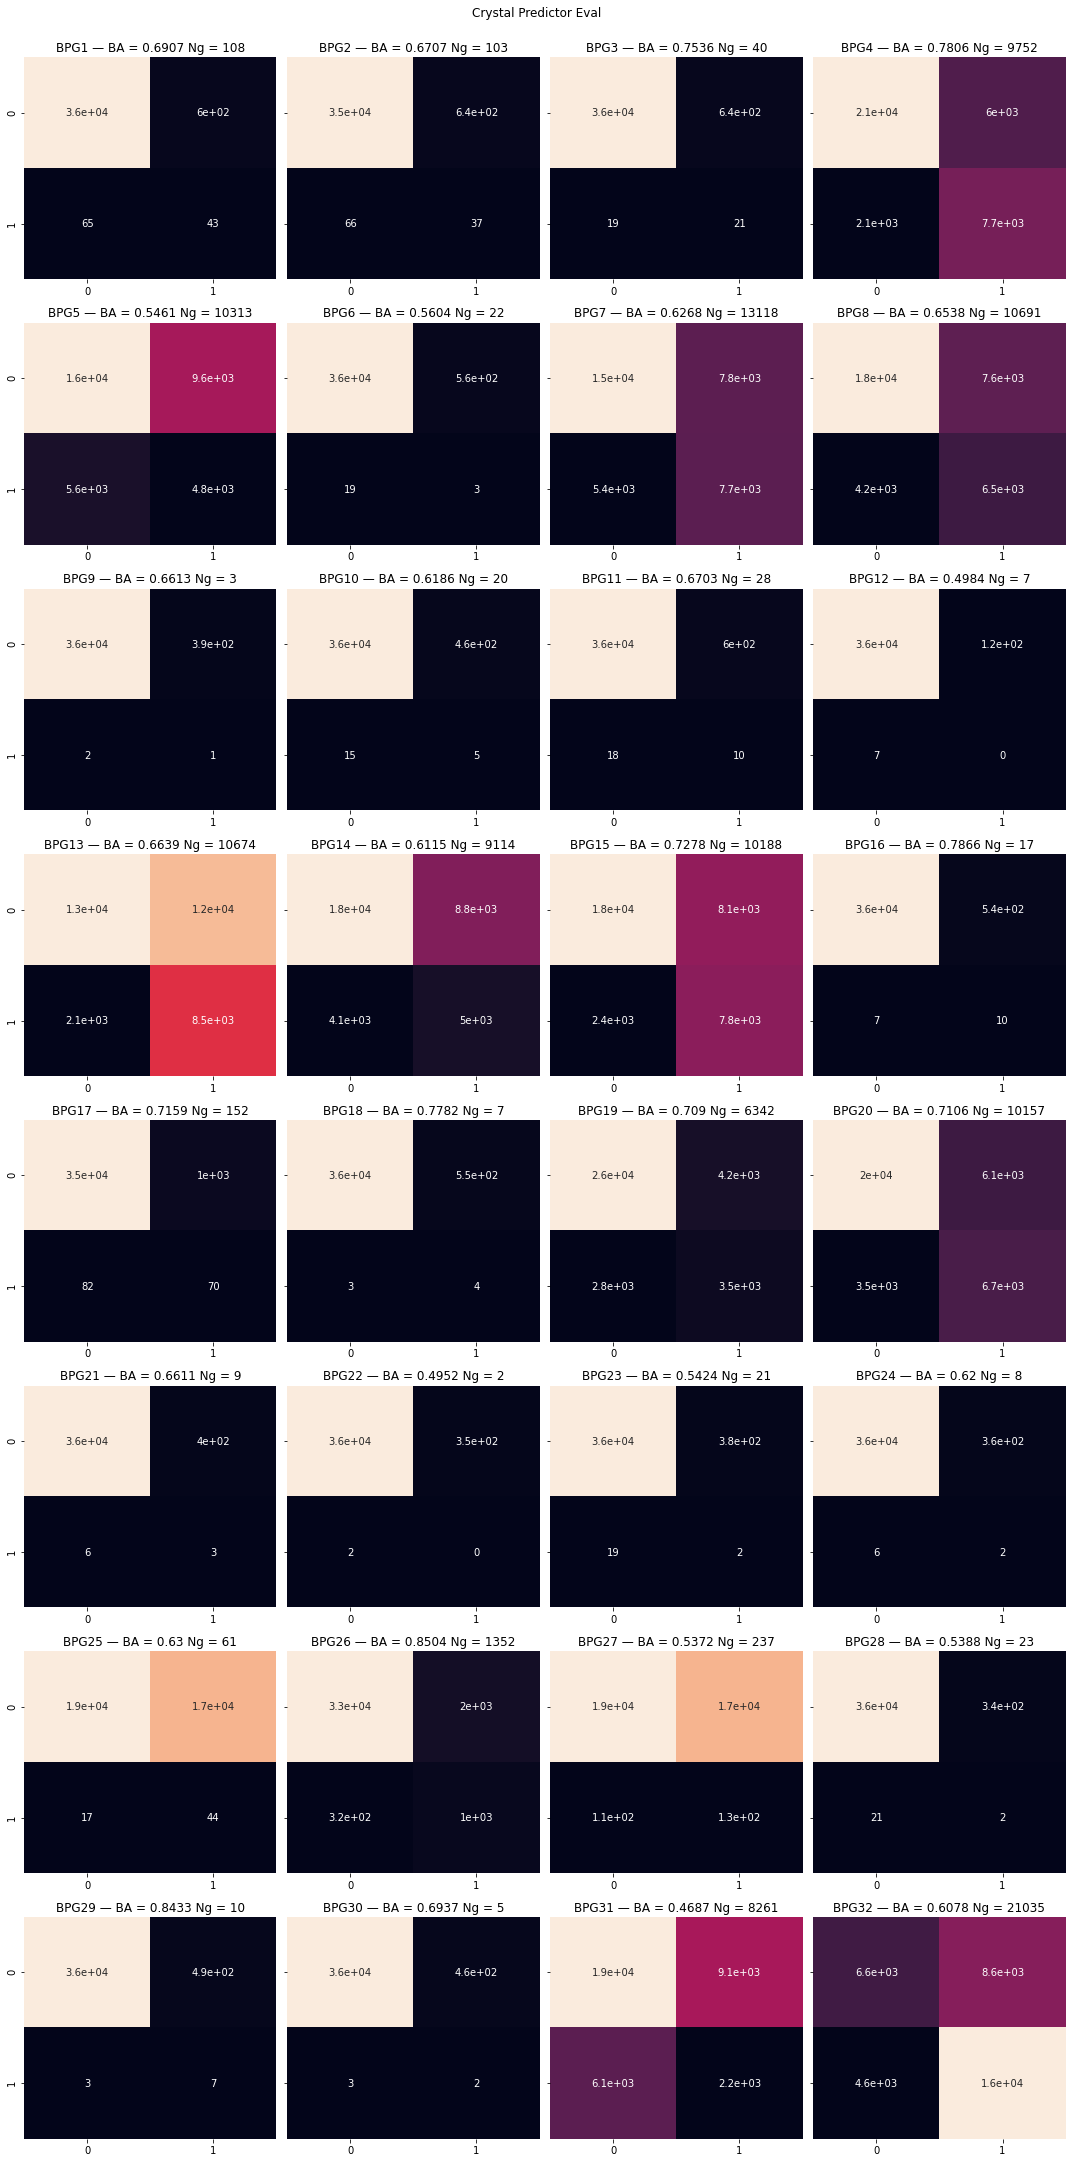

In [ ]:
fig, axes = plt.subplots(8, 4, figsize=(15, 30), sharey=True, sharex=False)
fig.suptitle('Crystal Predictor Eval', y=1)
idx = 0
ng_ba_list = []
f_scores = []
for ax_col in axes:
    for ax in ax_col:
        sns.heatmap(conf_matrices[idx], annot=True, ax=ax, cbar=False)
        metrics = evaluate_conf(conf_matrices[idx])
        title = class_names[idx] + " — BA = " + str(round(metrics['balanced_accuracy'], 4)) + ' Ng = ' + str(metrics['Ng'])
        ax.set_title(title)
        ng_ba = metrics['Ng'] * metrics['balanced_accuracy']
        f_scores.append(metrics['f_score'])
        ng_ba_list.append(ng_ba)
        idx+=1
        
plt.tight_layout()
plt.show()

In [ ]:
round(sum(ng_ba_list) / y_test.sum().sum(), 2)

0.65

In [ ]:
round(np.mean(f_scores), 2)

0.21


\begin{equation*}
\Large\text{WBA} = \frac{1}{N_p} \sum_{g=1}^{32} N_g \times BA_g = 65\%
\end{equation*}

\begin{equation*}
\Large\text{F1}_{macro} = \frac{1}{||G||} \sum_{g=1}^{32} 
\frac{2 \times \text{precision} \times \text{recall}}{\text{precision} + \text{recall}}  = 21\%
\end{equation*}

## Experiment 2 `Multi-Label Co-Occurrence Embedding Regression & Classification `

1. Co-Occurrence Graph
2. [LARGE-SCALE INFORMATION NETWORK EMBEDDING (LINE)](https://arxiv.org/pdf/1503.03578.pdf)
3. Random Forest Regressor
4. K-Nearest Neighbor

In [ ]:
X, y = get_dataset()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

In [ ]:
import joblib
import sys

sys.modules['sklearn.externals.joblib'] = joblib

In [ ]:
from skmultilearn.embedding import OpenNetworkEmbedder
from skmultilearn.cluster import LabelCooccurrenceGraphBuilder

In [ ]:
graph_builder = LabelCooccurrenceGraphBuilder(weighted=True, include_self_edges=False)
openne_line_params = dict(batch_size=1000, order=3)
embedder = OpenNetworkEmbedder(
    graph_builder,
    'LINE',
    dimension = 5*y_train.shape[1],
    aggregation_function = 'add',
    normalize_weights=True,
    param_dict = openne_line_params
)

In [ ]:
from skmultilearn.embedding import EmbeddingClassifier
from sklearn.ensemble import RandomForestRegressor
from skmultilearn.adapt import MLkNN

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import numpy

In [ ]:
clf = EmbeddingClassifier(
    embedder,
    RandomForestRegressor(n_estimators=10),
    MLkNN(k=5)
)

clf.fit(X_train.values, y_train.values)
predictions = clf.predict(X_test.values)

Pre-procesing for non-uniform negative sampling!

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.







Pre-procesing for non-uniform negative sampling!
epoch:0 sum of loss:4.599633991718292
epoch:0 sum of loss:4.60851389169693
epoch:1 sum of loss:4.577076554298401
epoch:1 sum of loss:4.618013322353363
epoch:2 sum of loss:4.485201954841614
epoch:2 sum of loss:4.53996467590332
epoch:3 sum of loss:4.459915399551392
epoch:3 sum of loss:4.546564340591431
epoch:4 sum of loss:4.4687305092811584
epoch:4 sum of loss:4.477407097816467
epoch:5 sum of loss:4.4399049282073975
epoch:5 sum of loss:4.422145128250122
epoch:6 sum of loss:4.432918608188629
epoch:6 sum of loss:4.450140297412872

C:\Users\ASUS\.conda\envs\newbase\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass n_neighbors=5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [ ]:
clf.embedder

EmbeddingClassifier(classifier=MLkNN(k=5),
                    embedder=<skmultilearn.embedding.openne.OpenNetworkEmbedder object at 0x0000027D4A75BE08>,
                    regressor=RandomForestRegressor(n_estimators=10),
                    require_dense=[True, True])

In [ ]:
conf_matrices = multilabel_confusion_matrix(y_test, predictions)
class_names = y_test.columns.tolist()

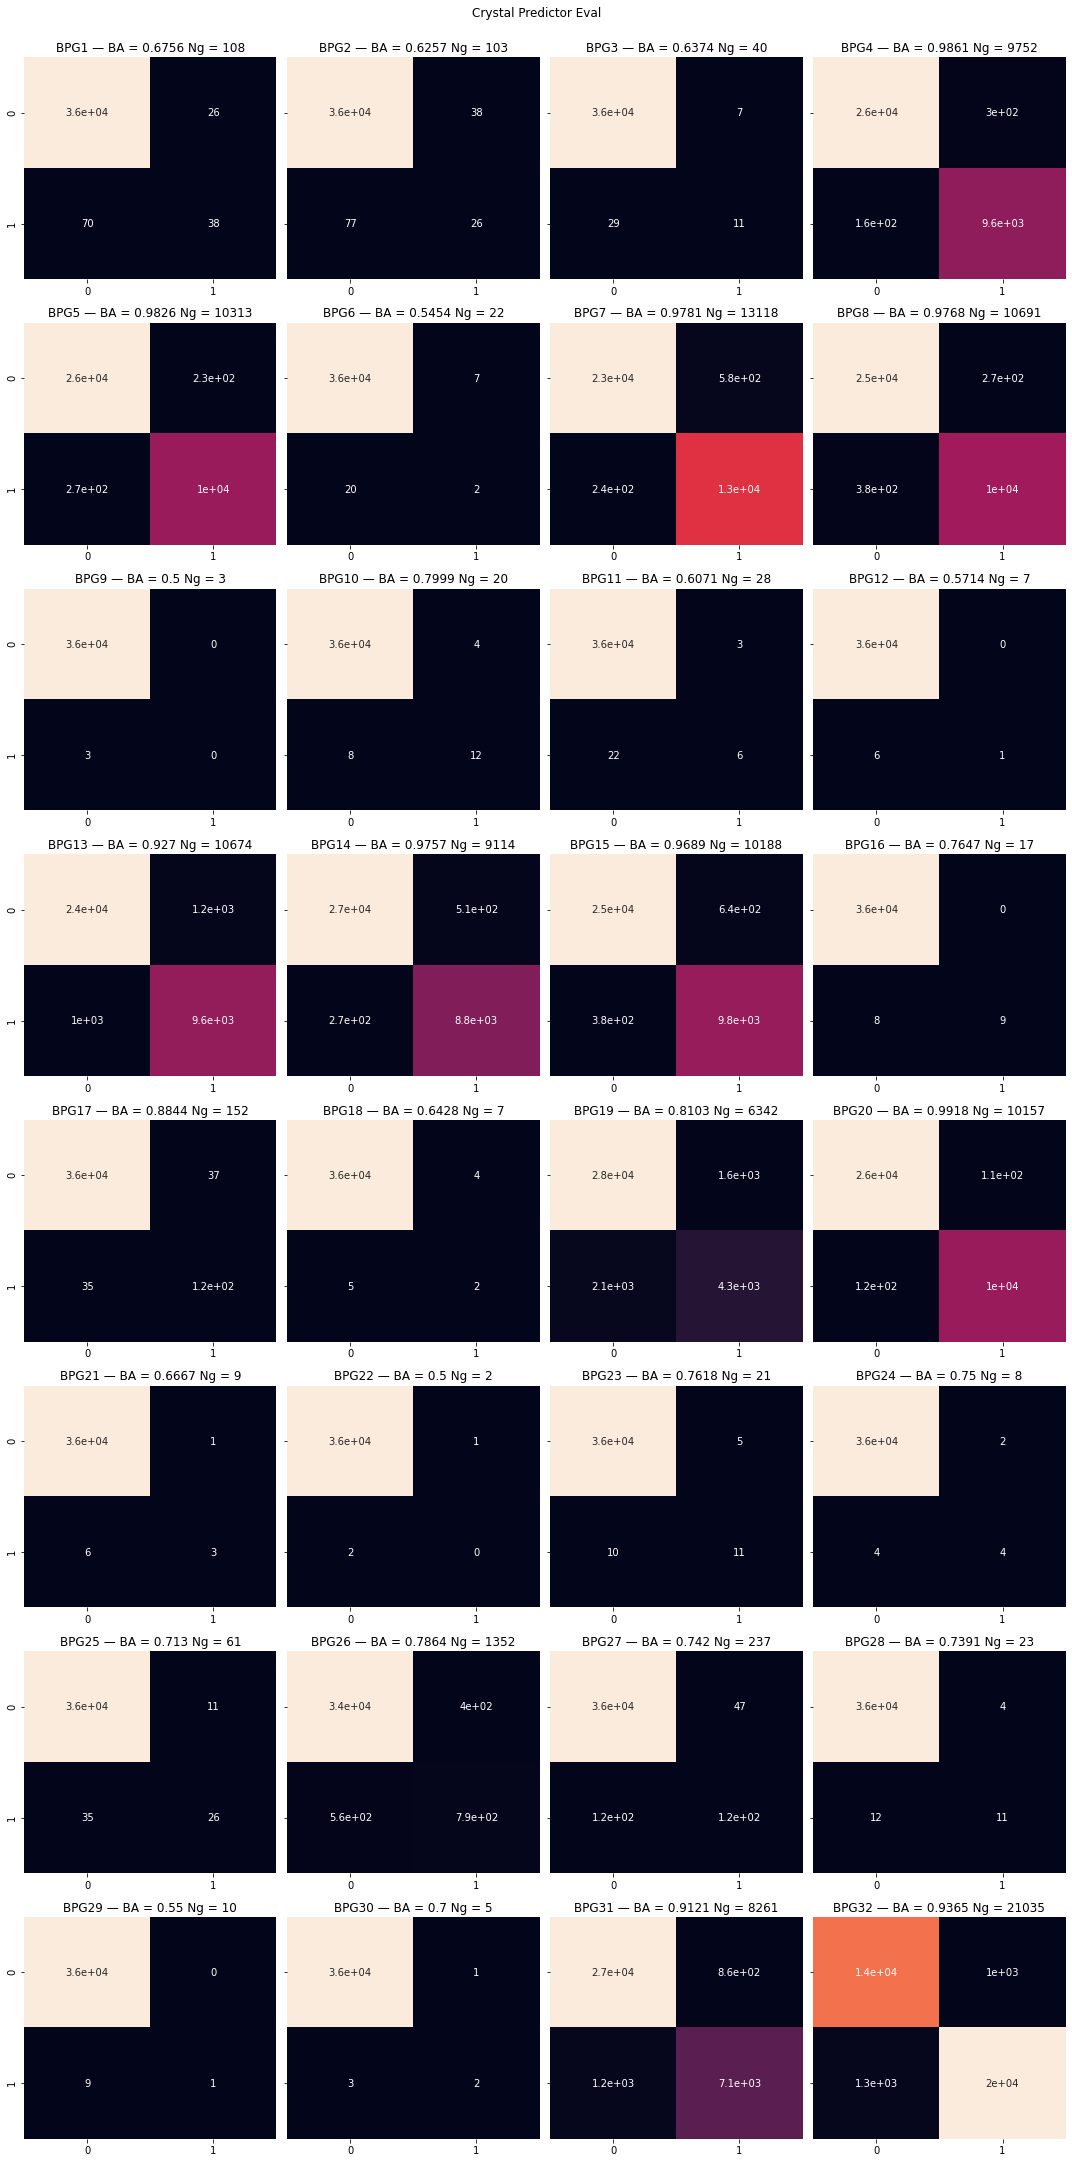

In [ ]:
fig, axes = plt.subplots(8, 4, figsize=(15, 30), sharey=True, sharex=False)
fig.suptitle('Crystal Predictor Eval', y=1)
idx = 0
ng_ba_list = []
f_scores = []
for ax_col in axes:
    for ax in ax_col:
        sns.heatmap(conf_matrices[idx], annot=True, ax=ax, cbar=False)
        metrics = evaluate_conf(conf_matrices[idx])
        title = class_names[idx] + " — BA = " + str(round(metrics['balanced_accuracy'], 4)) + ' Ng = ' + str(metrics['Ng'])
        ax.set_title(title)
        ng_ba = metrics['Ng'] * metrics['balanced_accuracy']
        f_scores.append(metrics['f_score'])
        ng_ba_list.append(ng_ba)
        idx+=1
        
plt.tight_layout()
plt.show()

In [ ]:
round(sum(ng_ba_list) / y_test.sum().sum(), 2)

0.95

In [ ]:
round(np.mean(f_scores), 2)

0.6


\begin{equation*}
\Large\text{WBA} = \frac{1}{N_p} \sum_{g=1}^{32} N_g \times BA_g = 95\%
\end{equation*}

\begin{equation*}
\Large\text{F1}_{macro} = \frac{1}{||G||} \sum_{g=1}^{32} 
\frac{2 \times \text{precision}_g \times \text{recall}_g}{\text{precision}_g + \text{recall}_g}  = 60\%
\end{equation*}